# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_CRNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CRNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [20, 10, 5]
        conv_kernel = [3, 5, 10]
        pool_kernel = [1, 2, 2]
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = [64]
        drop_out = [0.5]
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        self.conv3 = nn.Conv2d(in_channels = conv_channel[1], out_channels = conv_channel[2], kernel_size = conv_kernel[2])
        # self.bn3 = nn.BatchNorm2d(conv_channel[2])
        self.pool3 = nn.MaxPool2d(kernel_size = pool_kernel[2])
        img_size = np.floor((img_size - conv_kernel[2] + 1.0) / pool_kernel[2])
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[2])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x
    

In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_CRNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    # prediction = ['boring', 'horrible', 'calm', 'funny']
    prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 50 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (12, 14, 129, 50)
Single output data size: (2,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTKNet_CRNN(
  (conv1): Conv2d(14, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(780, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.10042201429605484 0.06860076940898176 0.0747704888081422
Train/Val/TEST Accuracy: 42.028985507246375 44.44444444444444 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09373138099908829 0.06785538412441383 0.0742806612359432
Train/Val/TEST Accuracy: 36.231884057971016 33.333333333333336 57.142857142857146
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09771901071071624 0.06836722963877644 0.07464570855067688
Train/Val/TEST Accuracy: 33.333333333333336 33.333333333333336 52.38095238095238
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09738399386405945 0.06844007589582664 0.07383724175243904
Train/Val/TEST Accuracy: 40.57971014492754 44.44444444444444 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09863756895065308 0.06842906280750564 0.07374266058156666
Train/Val/TEST Accuracy: 39.130434782608695 44.44444444444444 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09325828403234482 0.06849008635456105 0.0741141244

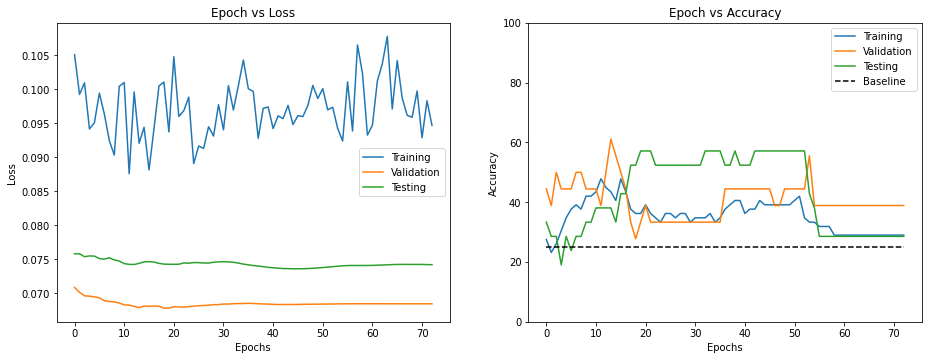

Train/Val/Test Final MSE: [0.09607854783535004, 0.06837296678309536, 0.07372023377545356]
Train/Val/Test Maximum Accuracy: [37.68115942028985, 44.44444444444444, 52.38095238095238]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08919837474822997 0.08994572983808918 0.07238887113635428
Train/Val/TEST Accuracy: 47.82608695652174 27.77777777777778 52.38095238095238
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08798431903123856 0.08997041393498269 0.07451218622944518
Train/Val/TEST Accuracy: 39.130434782608695 33.333333333333336 38.095238095238095
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09074122309684754 0.09041315057159711 0.07323379503283095
Train/Val/TEST Accuracy: 44.927536231884055 27.77777777777778 52.38095238095238
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09641723334789276 0.09063096472705941 0.07520735075533073
Train/Val/TEST Accuracy: 31.884057971014492 33.333333333333336 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09196607172489166 0.09083910587489502 0.0756610495005762
Train/Val/TEST Accuracy: 28.985507246376812 38.888888888888886 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08859805166721343 0.09087395369796367 0.07510932

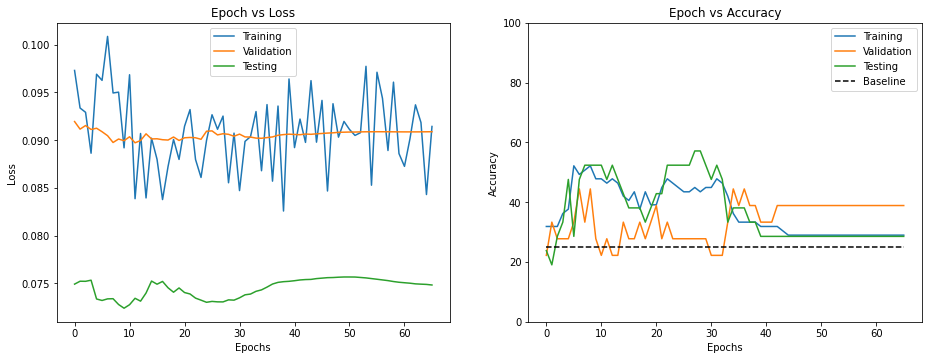

Train/Val/Test Final MSE: [0.08679890036582946, 0.09020091249072316, 0.07431136895939701]
Train/Val/Test Maximum Accuracy: [36.231884057971016, 44.44444444444444, 38.095238095238095]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07992594614624977 0.11322881911388215 0.0762483072550302
Train/Val/TEST Accuracy: 42.857142857142854 23.529411764705884 47.61904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08407993465662003 0.11136674114009913 0.07404141985794663
Train/Val/TEST Accuracy: 44.285714285714285 29.41176470588235 52.38095238095238
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08514563143253326 0.1123230375130387 0.07480617210828877
Train/Val/TEST Accuracy: 47.142857142857146 23.529411764705884 42.857142857142854
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08632304146885872 0.11354041198158965 0.0782784695897828
Train/Val/TEST Accuracy: 35.714285714285715 23.529411764705884 33.333333333333336
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.07779861651360989 0.11304991599172354 0.07714353897608817
Train/Val/TEST Accuracy: 38.57142857142857 17.647058823529413 33.333333333333336
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08879848718643188 0.11140900483245358 0.076034736

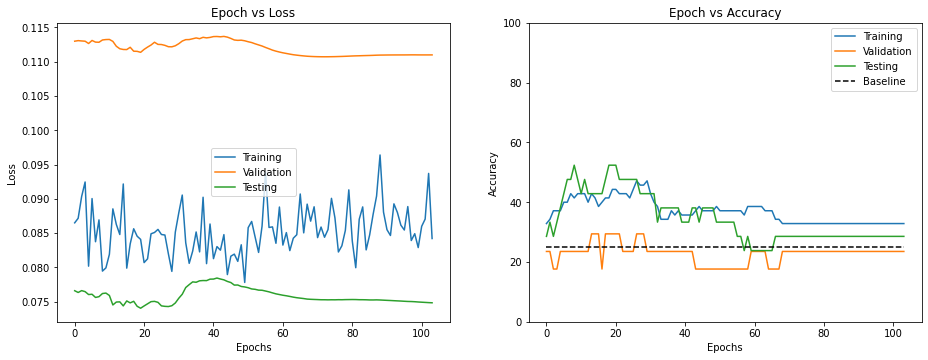

Train/Val/Test Final MSE: [0.08439266830682754, 0.11071649308809463, 0.07527498643252156]
Train/Val/Test Maximum Accuracy: [32.857142857142854, 23.529411764705884, 28.571428571428573]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08717861920595169 0.0888666459633147 0.07228199398239321
Train/Val/TEST Accuracy: 62.857142857142854 35.294117647058826 57.142857142857146
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08634386211633682 0.09041985540705569 0.07047691372558586
Train/Val/TEST Accuracy: 48.57142857142857 41.1764705882353 61.904761904761905
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08857878148555756 0.09045624732971191 0.07042161495787912
Train/Val/TEST Accuracy: 54.285714285714285 47.05882352941177 61.904761904761905
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08169300332665444 0.08925159916500836 0.07178590876199971
Train/Val/TEST Accuracy: 57.142857142857146 35.294117647058826 47.61904761904762
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0789000041782856 0.08982273037819301 0.07165011169300192
Train/Val/TEST Accuracy: 54.285714285714285 35.294117647058826 47.61904761904762
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08119484558701515 0.0900998064864646 0.06969745952

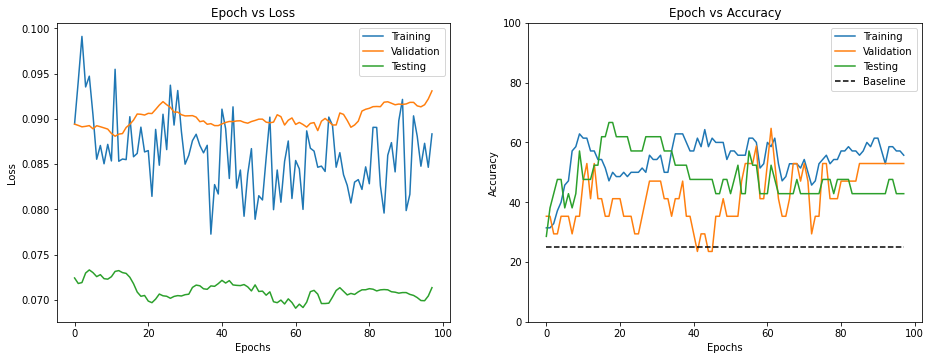

Train/Val/Test Final MSE: [0.08464994877576829, 0.08869827823603854, 0.07062472957893208]
Train/Val/Test Maximum Accuracy: [52.857142857142854, 41.1764705882353, 42.857142857142854]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08913310915231705 0.10438389966593069 0.07099297297065191
Train/Val/TEST Accuracy: 38.57142857142857 11.764705882352942 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.08227107673883438 0.10267148780472138 0.07447884026277322
Train/Val/TEST Accuracy: 47.142857142857146 17.647058823529413 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.07924103476107121 0.10098783671855927 0.07566828716898315
Train/Val/TEST Accuracy: 42.857142857142854 23.529411764705884 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08924290686845779 0.10096908240195583 0.07440963879058213
Train/Val/TEST Accuracy: 47.142857142857146 23.529411764705884 42.857142857142854
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09605689793825149 0.10185633643585093 0.07402233509403036
Train/Val/TEST Accuracy: 40.0 23.529411764705884 47.61904761904762
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08319194838404656 0.10134602699647932 0.07425434551814328
T

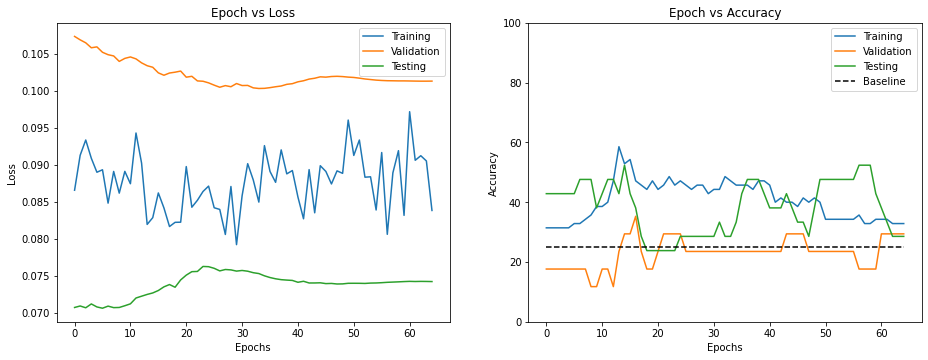

Train/Val/Test Final MSE: [0.08498367816209793, 0.1003217387067921, 0.07533719340010846]
Train/Val/Test Maximum Accuracy: [47.142857142857146, 23.529411764705884, 28.571428571428573]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.08738074868917464, 0.09166207786094877, 0.07385370242928253]
Train/Val/Test Average Accuracy: [41.35403726708075, 35.42483660130719, 38.095238095238095]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.4931539  0.46034595] with label  [0]
Target Example: [0.125 0.875] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.1537376344203949  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.48773518 0.45586395] with label  [0]
Target Example: [0.    0.375] with label  [0, 2]
Real Label Example: [10.  1. 10.  1.] with label  [0]
------- MSE: 0.12221229076385498  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.49742806 0.47069386] with label  [0]
Target Example: [0.125 0.375] with label  [0]
Real Label Example: [8. 1. 3. 1.] with label  [0]
------- MSE: 0.07392998784780502  Accuracy: 100.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.4986511 0.4682839] with label  [0]
Target Example: [0.75 0.5 ] with label  [3]
Real Label Example: [1. 1. 5. 8.] with label  [3, 2]
------- MSE: 0.03209109231829643  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.49762788 0.471211  ] wi

## 2D emotion plot

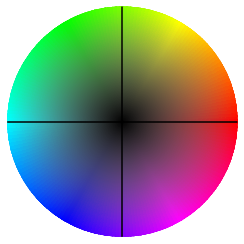

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


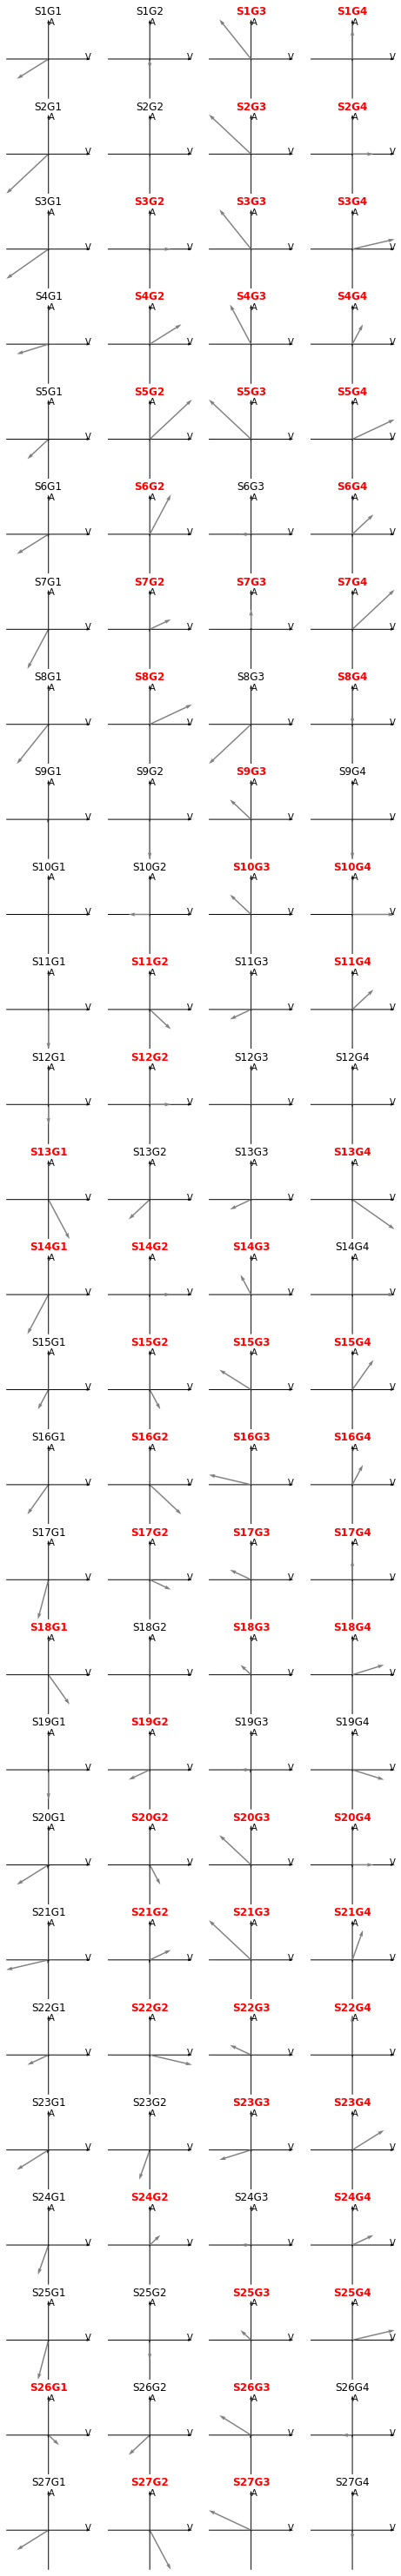

In [12]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 0 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
